In [11]:
import torchvision.models as models
import torchvision.datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [2]:
data_train = torchvision.datasets.FashionMNIST("fmnist", download=True, train=True, transform=torchvision.transforms.ToTensor())
data_loader_train = torch.utils.data.DataLoader(data_train,
                                          batch_size=256,
                                          shuffle=True,
                                          )

data_test = torchvision.datasets.FashionMNIST("fmnist", download=True, train=False, transform=torchvision.transforms.ToTensor())
data_loader_test = torch.utils.data.DataLoader(data_test,
                                          batch_size=256,
                                          shuffle=False)

0.4%Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz
100.0%
Extracting fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw

100.6%
0.3%Extracting fmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw

100.0%
Extracting fmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw

119.3%Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz
Extracting fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw

Processing...

C:\Users\CZ100108\Miniconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using th

In [3]:
dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}


In [4]:
len(data_loader_train), len(data_loader_test)

(235, 40)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, p_dropout):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(512, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
def mc_dropout(model, X, num_classes=10, T=100):
  model.train()
  softmax = nn.Softmax(dim=1)
  out=torch.zeros(T, X.shape[0] , num_classes)
  for i in range(T):
    with torch.no_grad():
      out[i]=softmax(model(X))
  return out

In [13]:
def normalized_entropy(probs, num_classes=10, **kwargs):
  return entropy(probs, **kwargs)/np.log(num_classes)

In [14]:
model = NeuralNetwork(p_dropout=.5).to("cpu")
print(model)
num_epochs =  15
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    for phase in ['train', 'val']:
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode
      running_loss = 0.0
      running_corrects = 0
      running_entropy = 0.0
      running_maxes = 0.0
      for inputs, labels in data_loaders[phase]:
        optimizer.zero_grad()
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          maxs, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          probs = softmax(outputs)
          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          running_entropy += np.sum(1-normalized_entropy(probs.detach().numpy(), axis=1))
          running_maxes += torch.sum(torch.max(probs))
          # backward + optimize only if in training phase
          if phase == 'train':
              loss.backward()
              optimizer.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      epoch_entropy = running_entropy / dataset_sizes[phase]
      epoch_avg_max = running_maxes / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f} Avg. conf: {:.4f} Avg. max. prob: {:.4f}'.format(
              phase, epoch_loss, epoch_acc, epoch_entropy, epoch_avg_max))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 0/14
----------
train Loss: 2.1107 Acc: 0.3859 Avg. conf: 0.0122 Avg. max. prob: 0.0008
val Loss: 1.7814 Acc: 0.4942 Avg. conf: 0.0531 Avg. max. prob: 0.0015
Epoch 1/14
----------
train Loss: 1.4242 Acc: 0.5585 Avg. conf: 0.1955 Avg. max. prob: 0.0027
val Loss: 1.1382 Acc: 0.6403 Avg. conf: 0.3186 Avg. max. prob: 0.0031
Epoch 2/14
----------


KeyboardInterrupt: 

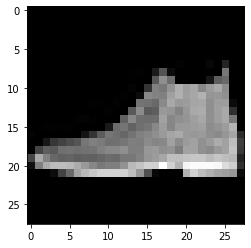

In [ ]:
X,y = data_test[0]
plt.imshow(X[0], cmap="gray")

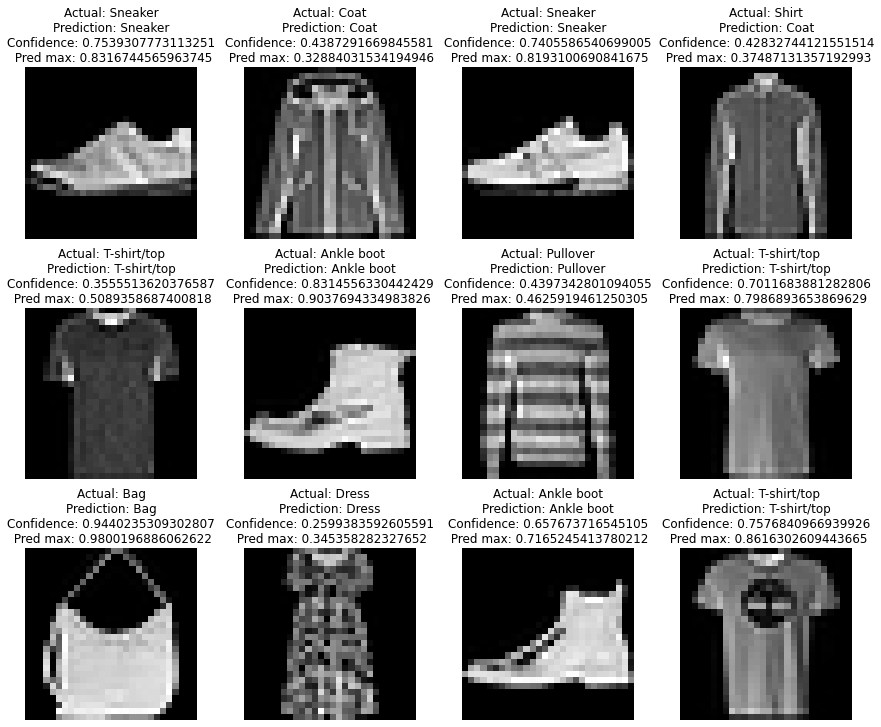

In [ ]:
 num_rows = 3
 num_cols = 4
 inputs, classes = next(iter(data_loader_test))  
 inputs = inputs[:num_rows*num_cols]
 classes = classes[:num_rows*num_cols]
 class_names=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


with torch.no_grad():
  softmax = nn.Softmax(dim=1)
  predictions= softmax(model(inputs))
uncertainties = normalized_entropy(predictions, axis=1)

 r_index = 0
 c_index = 0
 fig, axs = plt.subplots(num_rows,  num_cols, figsize=(15,12))
 for i,(x,y) in enumerate(zip(inputs,classes)):
   ax = axs[r_index][c_index]
   ax.axis("off")
   ax.imshow(x[0], cmap="gray")
   predicted = torch.argmax(predictions[i])
   ax.set_title(f"Actual: {class_names[y]}\nPrediction: {class_names[predicted]}\nConfidence: {1-uncertainties[i]}\n Pred max: {torch.max(predictions[i])}")
   c_index += 1
   if c_index >= num_cols:
     r_index +=1
     c_index= 0
plt.subplots_adjust(hspace=.4)
